Tukaj sem uporabil 2 dataseta celic mišjih možganov. Za markerje sem uporabil bazo Panglao Gene Markers.

Dataset Hrvatin (2018) sem uporabil za treniranje mreže, ker ima več celic in razredov.

In [1]:
from anndata import read_h5ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Orange.data import Table
from tensorflow.python.keras.callbacks import TensorBoard
from time import time
%matplotlib inline

SPECIES = 'Mouse'
DATASET_1_PATH = '/home/mlongar/Data/SingleCellGeneExpression/hrvatin_2018.h5ad'
DATASET_2_PATH = '/home/mlongar/Data/SingleCellGeneExpression/chen_2017.h5ad'
MARKER_PATH = '/home/mlongar/Data/SingleCellGeneExpression/panglao_gene_markers.tab.gz'

In [2]:
EPOCHS = 60
BOTTLENECK = 25

# Load the data

In [3]:
dataset = read_h5ad(DATASET_1_PATH)
data = dataset.to_df()
labels = dataset.obs["labels"]

new_dataset = read_h5ad(DATASET_2_PATH)
new_data = new_dataset.to_df()
new_labels = new_dataset.obs["labels"]

markers = Table(MARKER_PATH)

In [4]:
print(data.shape)
print(new_data.shape)

(48266, 25186)
(14437, 23284)


Hrvatin ima 48266 celic in 25186 genov.

Chen ima 14437 celic in 23284 genov.

# Drop rows

Iz podatkov sem odstranil vse neklasificirane celice.

Iz 2. dataseta sem tudi odstranil vse razrede, ki jih ni v 1. (učnem) datasetu.

In [5]:
to_drop = []
new_to_drop = []
for i, c_type in enumerate(labels.tolist()):
    if c_type == 'Other':
        to_drop.append(i)
for i, c_type in enumerate(new_labels.tolist()):
    if c_type == 'unknown' or c_type == 'tanycyte' or c_type == 'ependymal cell' or c_type == 'epithelial cell':
        new_to_drop.append(i)

In [6]:
data = data.drop(data.index[to_drop], axis=0)
labels = labels.drop(labels.index[to_drop], axis=0)

new_data = new_data.drop(new_data.index[new_to_drop], axis=0)
new_labels = new_labels.drop(new_labels.index[new_to_drop], axis=0)

In [7]:
print(labels.shape)
print(data.shape)

print('\n')

print(new_labels.shape)
print(new_data.shape)

(48266,)
(48266, 25186)


(9687,)
(9687, 23284)


# Load marker genes

#### Load only the specified marker genes

In [8]:
markers_db = []
for meta in markers.metas:
    if meta[0] == SPECIES:
        markers_db.append(meta)

#### Get the used marker genes

In [9]:
def get_used_markers(data, markers=markers_db):
    used_markers = []
    for i, gene_name in enumerate(data.columns):
        for marker in markers:
            if gene_name == marker[1]:
                used_markers.append((gene_name, marker))
    return used_markers

used_markers = get_used_markers(data)
new_used_markers = get_used_markers(new_data)

In [10]:
markers_to_keep = []
for marker in used_markers:
    marker_found = False
    for new_marker in new_used_markers:
        if marker[0] == new_marker[0] and marker[1][2] == new_marker[1][2]:
            markers_to_keep.append(marker)

In [11]:
print(len(used_markers), len(new_used_markers))
print(len(markers_to_keep))

7675 7477
7390


### Get the cell types

In [12]:
from collections import OrderedDict

def get_cell_types(used_markers):
    cell_types = OrderedDict()
    for marker in used_markers:
        c_type = marker[1][2]
        gene_name = marker[0]
        if c_type in cell_types:
            if gene_name not in cell_types[c_type]:
                cell_types[c_type].append(gene_name)
        else:
            cell_types[c_type] = [gene_name]
    return cell_types

cell_types = get_cell_types(markers_to_keep)
#cell_types = get_cell_types(used_markers)

### Make sure every class is in the marker layer

In [13]:
def get_used_genes(cell_types):
    used_genes = []
    for c_type in cell_types:
        genes = cell_types[c_type]
        for gene in genes:
            if gene not in used_genes:
                used_genes.append(gene)
    return used_genes

used_genes = get_used_genes(cell_types)

In [14]:
marker_names = {'Neuron' : 'Neurons',
                'Oligodendrocyte' : 'Oligodendrocytes',
                'Muscle cell' : 'Smooth muscle cells',
                'Endothelial cell' : 'Endothelial cells',
                'Astrocyte' : 'Astrocytes',
                'Macrophage' : 'Macrophages',
                'OPC' : 'Oligodendrocyte progenitor cells',
                'Pericyte' : 'Pericytes'}

used_types = []
for c_type in cell_types:
    used_types.append(c_type)

for c_type in labels.unique():
    if c_type not in used_types and c_type not in list(marker_names.keys()):
        print(c_type)
for c_type in new_labels.unique():
    if c_type not in used_types and c_type not in list(marker_names.keys()):
        print(c_type)

# Gene selection

In [15]:
gene_mask = np.zeros(len(data.columns), dtype=bool)
new_gene_mask = np.zeros(len(new_data.columns), dtype=bool)

In [16]:
to_drop = []
for i, keep in enumerate(gene_mask):
    gene_name = data.columns[i]
    if keep == False and gene_name not in used_genes:
        to_drop.append(data.columns[i])

new_to_drop = []
for i, keep in enumerate(new_gene_mask):
    gene_name = new_data.columns[i]
    if keep == False and gene_name not in used_genes:
        new_to_drop.append(new_data.columns[i])

In [17]:
data.shape[1] - len(to_drop)

4082

In [18]:
new_data.shape[1] - len(new_to_drop)

4082

## Drop unused genes

In [19]:
data = data.drop(to_drop, axis=1)
new_data = new_data.drop(new_to_drop, axis=1)

## Sort columns by name

In [20]:
data = data.reindex(sorted(data.columns), axis=1)
new_data = new_data.reindex(sorted(new_data.columns), axis=1)

In [21]:
new_data.columns.values == data.columns.values

array([ True,  True,  True, ...,  True,  True,  True])

# Data transformation

#### Shuffle the data

In [22]:
idx = np.random.permutation(data.index)
data_x = data.reindex(idx)
data_y = labels.reindex(idx)

#### Log10 transformation

In [23]:
data_x = np.log10(data_x + 1)
new_data_x = np.log10(new_data + 1)

#### Split the data

In [24]:
seventy = int(data_x.shape[0] * 0.7)
fifteen = int(data_x.shape[0] * 0.15)

In [25]:
train_x = data_x[:seventy]
train_y = data_y[:seventy]

test_x = data_x[seventy:seventy+fifteen]
test_y = data_y[seventy:seventy+fifteen]

validation_x = data_x[seventy+fifteen:]
validation_y = data_y[seventy+fifteen:]

In [26]:
data.shape

(48266, 4082)

In [27]:
new_data.shape

(9687, 4082)

# Build the model

In [28]:
from keras import backend as K
from keras.layers import Layer
from keras import activations, initializers, regularizers, constraints
from keras.engine.base_layer import InputSpec
from tensorflow import convert_to_tensor
import tensorflow as tf

class Markers(Layer):

    def __init__(self, units, weight_mask,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Markers, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True
        
        weight_mask = convert_to_tensor(np.transpose(weight_mask), dtype=tf.float32)
        self.weight_mask = weight_mask

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        conns = tf.multiply(self.kernel, self.weight_mask)
        output = K.dot(inputs, conns)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer':
                regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(Markers, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Using TensorFlow backend.


In [29]:
def get_weight_mask(types, n_dim, num_types, data=data):
    mask = np.zeros(shape=(num_types, n_dim))
    for i, cell_type in enumerate(types):
        for gene in types[cell_type]:
            gene_index = data.columns.get_loc(gene)
            mask[i][gene_index] = 1.0
    return mask

In [30]:
from keras.layers import Input, Dense, Add, Dropout
from keras.models import Model

def build_model(input_dim, marker_dim, bottleneck_dim, types=cell_types):
    weight_mask = get_weight_mask(types=types, num_types=num_types, n_dim=input_dim)
    
    input_layer = Input(shape=(input_dim,))
    marker_layer = Markers(marker_dim, weight_mask=weight_mask, activation='relu')(input_layer)
    
    dense_in_1 = Dense(100, activation='relu')(marker_layer)
    bottleneck_layer = Dense(bottleneck_dim, activation='relu', name='Bottleneck')(dense_in_1)
    dense_out_1 = Dense(100, activation='relu')(bottleneck_layer)
    dropout = Dropout(0.1)(dense_out_1)
    
    output_layer = Dense(input_dim, activation='relu', name='Output')(dropout)
    
    model = Model(input_layer, output_layer)
    model.compile(loss='mse', optimizer='adam')
    
    marker_model = Model(input_layer, marker_layer)
    marker_model.compile(loss='mse', optimizer='adam')
    
    encoder_model = Model(input_layer, bottleneck_layer)
    encoder_model.compile(loss='mse', optimizer='adam')
    
    return model, marker_model, encoder_model

def train_model(model, data, validation_data, test_data, epochs=30, batch_size=256, verbose=1, callbacks=[]):
    history = model.fit(data, data,
               epochs=epochs, batch_size=batch_size,
               validation_data=(validation_data, validation_data),
               callbacks=callbacks,
               verbose=verbose)
    loss = model.evaluate(test_data, test_data)
    return (history, loss)

def draw_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss', c='orange')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

#### Create the model

In [31]:
n_genes = train_x.shape[1]
num_types = len(cell_types)

model, marker_model, encoder_model = build_model(input_dim=n_genes,
                                                 marker_dim=num_types,
                                                 bottleneck_dim=BOTTLENECK,
                                                 types=cell_types)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4082)              0         
_________________________________________________________________
markers_1 (Markers)          (None, 179)               730857    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               18000     
_________________________________________________________________
Bottleneck (Dense)           (None, 25)                2525      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
Output (Dense)               (None, 4082)              412282    
Total para

# Train the model

In [33]:
history, loss = train_model(model, train_x, validation_x, test_x, epochs=EPOCHS, verbose=0, callbacks=[])#tensorboard

Instructions for updating:
Use tf.cast instead.
7239/7239 [==============================] - 2s 243us/step


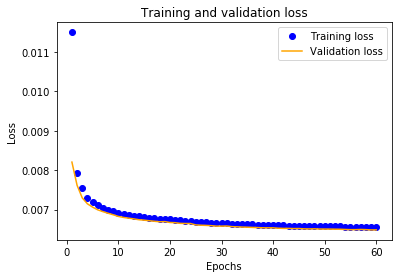

In [34]:
draw_history(history)

In [35]:
print("Test loss: ", loss)

Test loss:  0.006485266103442037


#### Save the model

In [36]:
model.save('markersonly_comparison.h5')
marker_model.save('markersonly_comparison_marker.h5')
encoder_model.save('markersonly_comparison_encoder.h5')

model.save_weights('markersonly_comparison_weights.h5')
marker_model.save_weights('markersonly_comparison_marker_weights.h5')
encoder_model.save_weights('markersonly_comparison_encoder_weights.h5')

# Data analysis

In [37]:
def get_results(cell_types, cell_activations, graph_labels):
    types_list = list(cell_types.items())
    top3s = []
    top3s_act = []
    for cell in cell_activations:
        top3 = cell.argsort()[-3:][::-1]
        top3types = [types_list[i][0] for i in top3]
        top3s.append(top3types)
        
        act = np.zeros((len(cell_activations[0]),))
        for i in top3:
            act[i] = cell[i]
        top3s_act.append(act)

    n = 0
    correct = 0
    for i in range(len(top3s)):
        prediction = top3s[i][0]
        label = graph_labels.iloc[i]

        if str(prediction) == 'nan' or str(label) == 'nan':
            continue

        if prediction == label:
            correct += 1

        elif label in marker_names.keys():
            if marker_names[label] == prediction:
                correct += 1
        n += 1

    print("Correct predictions: {c} out of {n} ({p}%)".format(c=correct, n=n, p=round(100 * (correct/n), 2)))
    print("Dropped {d} cells".format(d=len(cell_activations) - n))
    return top3s_act

In [38]:
cell_activations = marker_model.predict(test_x)
bottleneck_activations = encoder_model.predict(test_x)
graph_labels = test_y

In [39]:
top3 = get_results(cell_types, cell_activations, graph_labels)

Correct predictions: 6539 out of 7239 (90.33%)
Dropped 0 cells


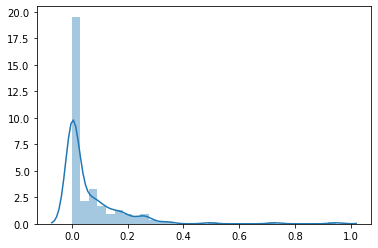

In [40]:
import seaborn as sns
sns.distplot(cell_activations[21])

### New data

In [41]:
new_cell_activations = marker_model.predict(new_data_x)
new_bottleneck_activations = encoder_model.predict(new_data_x)
new_graph_labels = new_labels

In [42]:
new_top3 = get_results(cell_types, new_cell_activations, new_graph_labels)

Correct predictions: 8512 out of 9687 (87.87%)
Dropped 0 cells


## Graphs

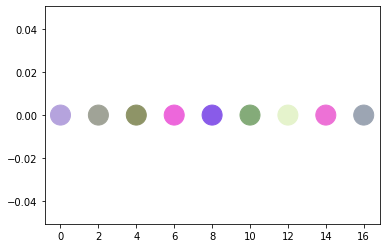

In [43]:
import random
from time import time

def get_random_color(pastel_factor = 0.5):
    pastel_factor = random.uniform(0, 1.0)
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

colours = {}
for label in graph_labels.unique():
    random.seed = time() + random.randint(-1000, 1000)
    colour = (get_random_color())
    colours.update({label:colour})
    
fig = plt.figure()
ax = fig.add_subplot(111)

x = list(range(0, len(colours.values()) * 2, 2))
y = [0]*len(x)
c = list(colours.values())

ax.scatter(x,y,s=400,c=c)

plt.show()

In [44]:
import pickle

pickle_in = open("Data/Marker_Colours.pickle","rb")
colours = pickle.load(pickle_in)

In [45]:
pickle_out = open("Data/Marker_Colours.pickle","wb")
pickle.dump(colours, pickle_out)
pickle_out.close()

In [46]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import OrderedDict
import operator

tnse = TSNE()
pca = PCA()
    
def draw_graph(x, y, model, colours, graph_name='', subset=1.0):
    subset_indices = list(range(0, len(x)))
    subset_indices = random.sample(subset_indices, k=int(len(x) * subset))
    new_x = []
    new_y = []
    for i in range(len(x)):
        if i in subset_indices:
            new_x.append(x[i])
            new_y.append(y[i])

    tsne_out = model.fit_transform(new_x)
    
    plt.clf()
    plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

    for i, entry in enumerate(tsne_out):
        plt.scatter(entry[0], entry[1], color=colours[new_y[i]], label=new_y[i])
    
    handles, plt_labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(plt_labels, handles))
    by_label = OrderedDict(sorted(by_label.items()))

    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0., 1, 0, .1))

    plt.title(graph_name)
    plt.axis('off')
    plt.show()

<Figure size 432x288 with 0 Axes>

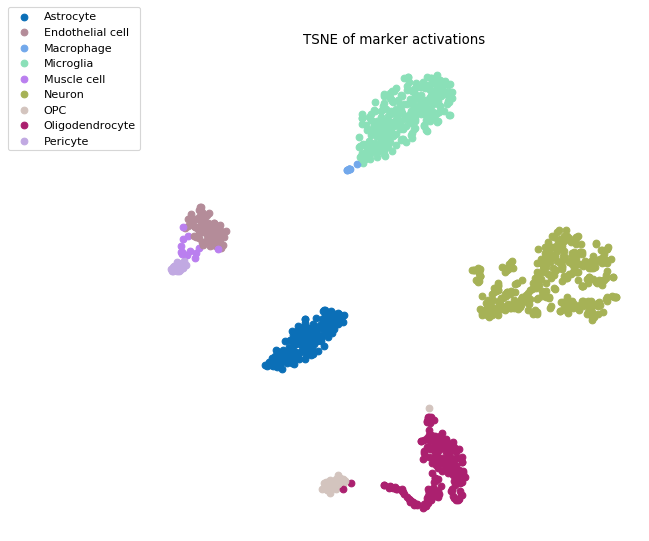

In [47]:
draw_graph(cell_activations, graph_labels, tnse, colours, graph_name='TSNE of marker activations', subset=0.15)

# New Data

<Figure size 432x288 with 0 Axes>

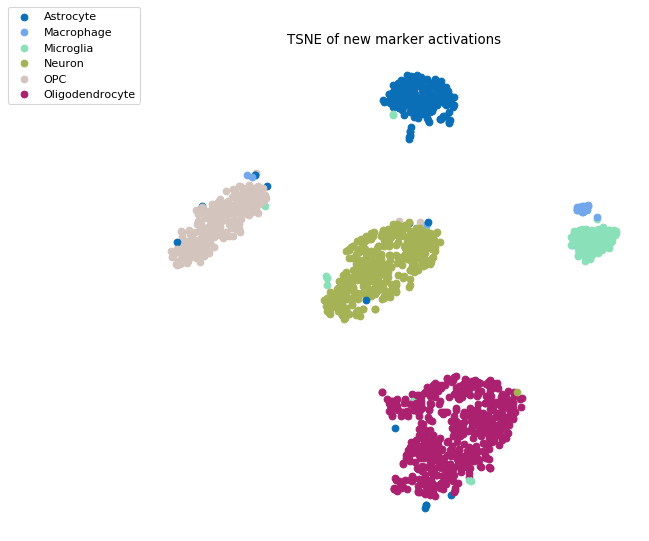

In [48]:
draw_graph(new_cell_activations, new_graph_labels, tnse, colours, subset=0.15,
           graph_name='TSNE of new marker activations')

# Save the data

In [49]:
in_data = pd.DataFrame(new_data_x)
out_data = pd.DataFrame(data=model.predict(new_data_x))
in_data.to_pickle('Data/in_data_markersonly.pickle')
out_data.to_pickle('Data/out_data_markersonly.pickle')

# Reconstruction

In [50]:
reconstruction = model.predict(new_data_x)
reconstruction = pd.DataFrame(reconstruction, columns=new_data_x.columns)
reconstructed_cell_activations = marker_model.predict(reconstruction)

**V tem primeru se je klasifikacijska točnost na rekonstuiranih podatkih povečala za 4%.**

In [51]:
_ = get_results(cell_types, reconstructed_cell_activations, new_graph_labels)

Correct predictions: 9069 out of 9687 (93.62%)
Dropped 0 cells


<Figure size 432x288 with 0 Axes>

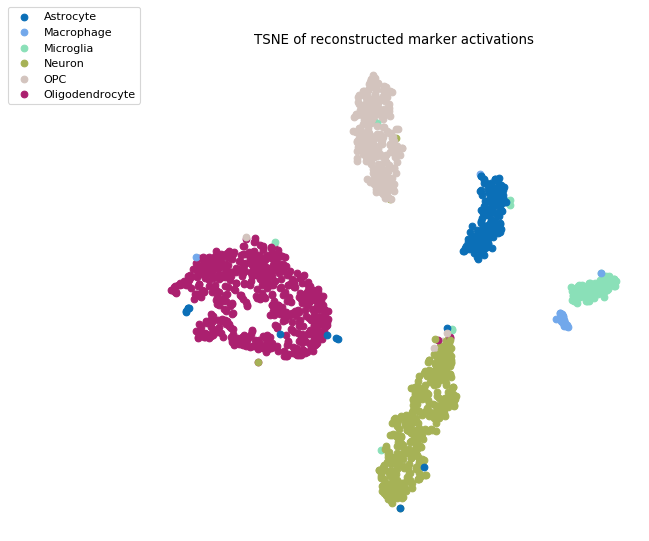

In [52]:
draw_graph(reconstructed_cell_activations, new_graph_labels, tnse, colours, subset=0.15,
           graph_name='TSNE of reconstructed marker activations')